In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

DB = r"/Users/a/Desktop/cursor/PythonPandas/SteamDataAnalysis/steam_analysis.db"
conn = sqlite3.connect(DB)

genre = pd.read_sql("SELECT * FROM view_genre_summary", conn)
play = pd.read_sql("SELECT * FROM view_playtime_stats", conn)
review = pd.read_sql("SELECT * FROM view_review_stats", conn)
moi_raw = pd.read_sql("SELECT * FROM view_market_opportunity", conn)
conn.close()

# 1. 장르별 평균 플레이타임 TOP 15

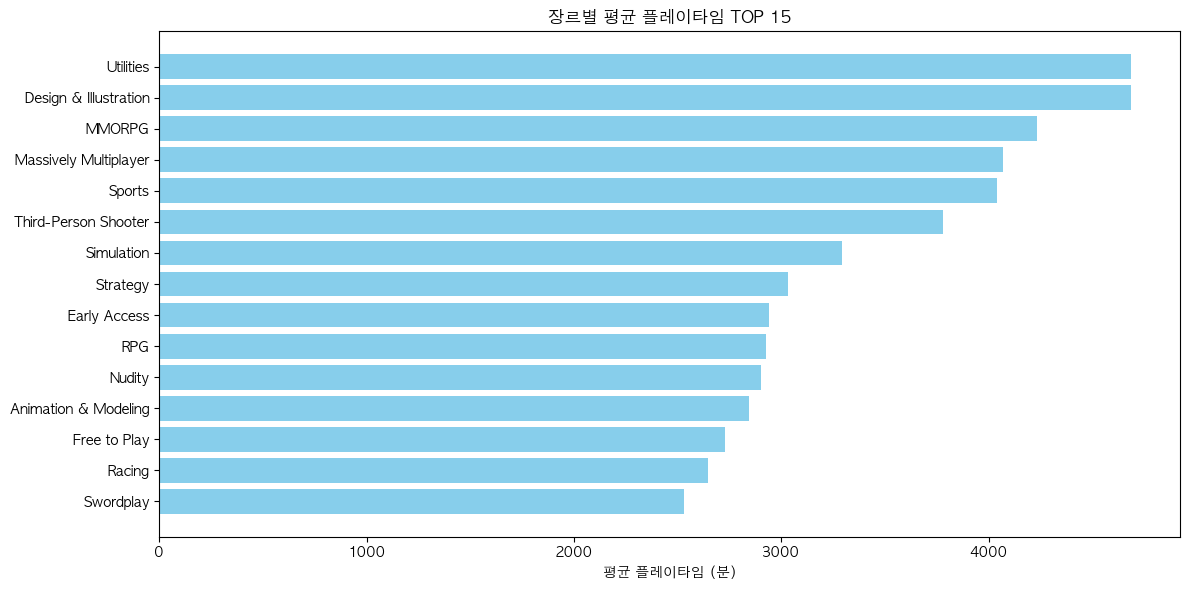

In [18]:
top15_play = genre.sort_values("avg_playtime", ascending=False).head(15)

plt.figure(figsize=(12,6))
plt.barh(top15_play["genre_name"], top15_play["avg_playtime"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("평균 플레이타임 (분)")
plt.title("장르별 평균 플레이타임 TOP 15")
plt.tight_layout()
plt.show()

# 2. 가격 vs 플레이타임 (장르)

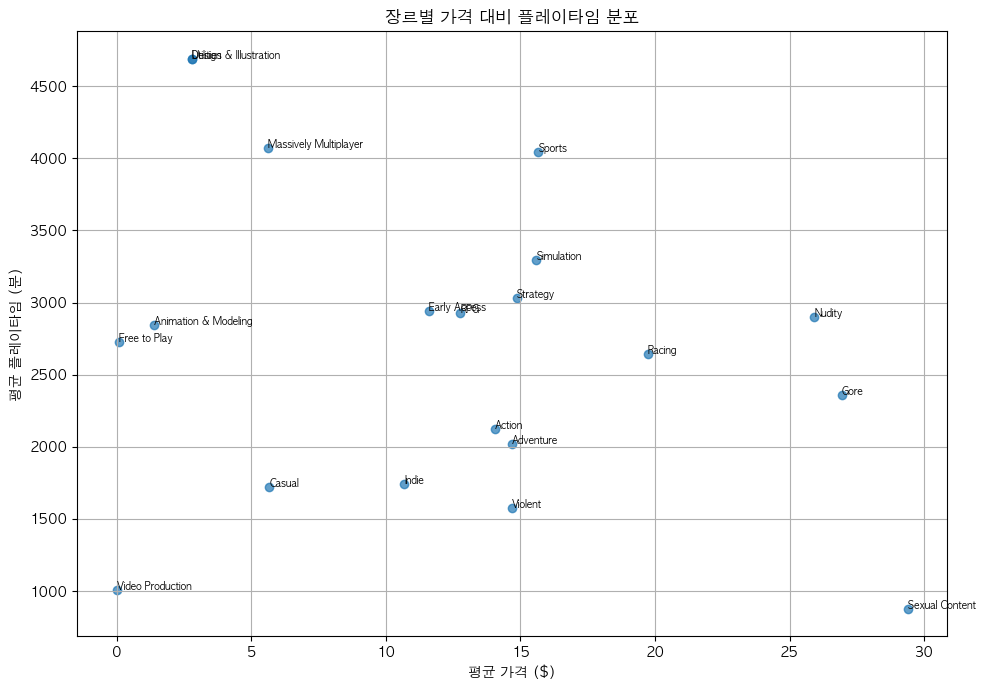

In [19]:
plt.figure(figsize=(10,7))
plt.scatter(genre["avg_price"], genre["avg_playtime"], alpha=0.7)

for _, row in genre.iterrows():
    plt.text(row["avg_price"], row["avg_playtime"], row["genre_name"], fontsize=7)

plt.xlabel("평균 가격 ($)")
plt.ylabel("평균 플레이타임 (분)")
plt.title("장르별 가격 대비 플레이타임 분포")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 가성비 기반 장르 TOP 20

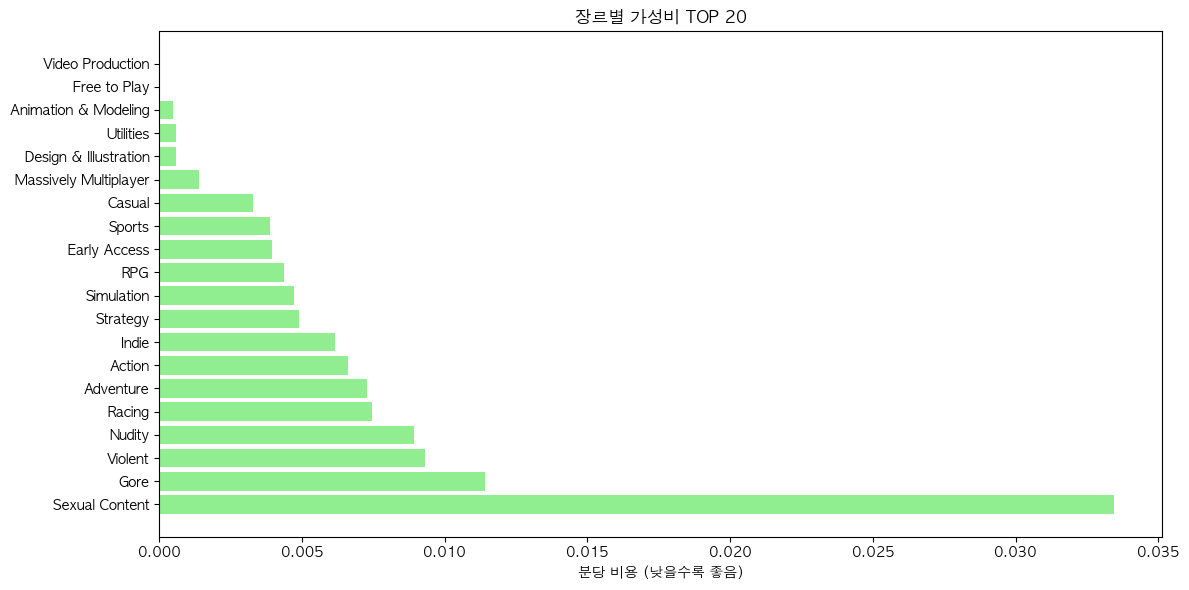

In [20]:
genre["price_time_gap"] = genre["avg_price"] / (genre["avg_playtime"] + 1)
top_ptg = genre.sort_values("price_time_gap").head(20)

plt.figure(figsize=(12,6))
plt.barh(top_ptg["genre_name"], top_ptg["price_time_gap"], color="lightgreen")
plt.gca().invert_yaxis()
plt.xlabel("분당 비용 (낮을수록 좋음)")
plt.title("장르별 가성비 TOP 20")
plt.tight_layout()
plt.show()

# 4. 긍정률 하위 15 (문제 장르)

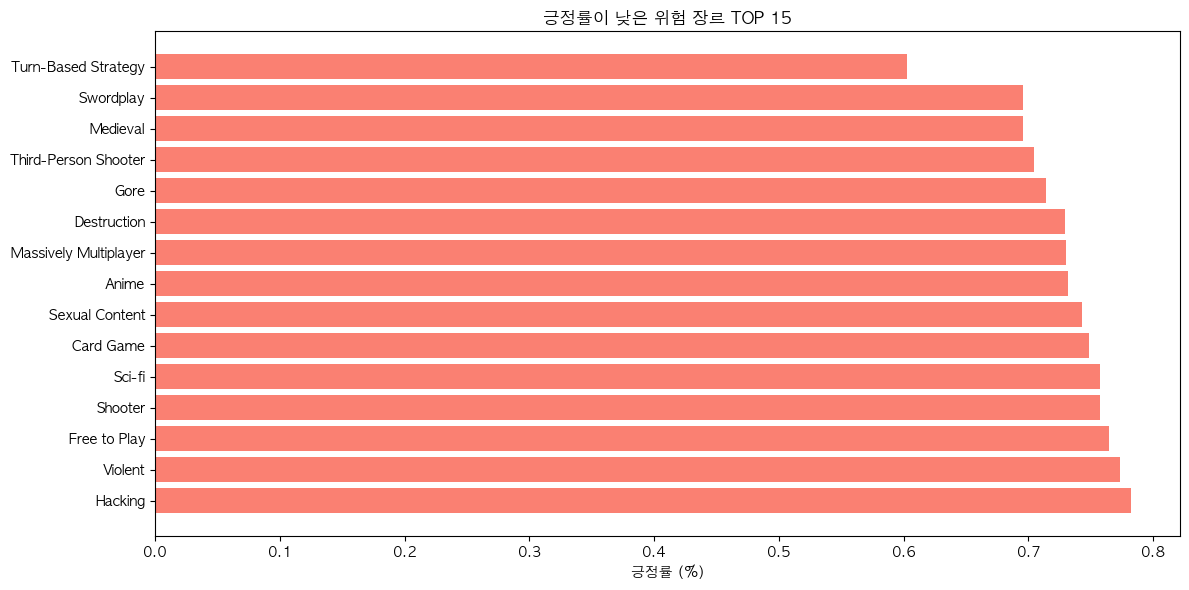

In [21]:
bottom15_pos = genre.sort_values("avg_positive_rate").head(15)

plt.figure(figsize=(12,6))
plt.barh(bottom15_pos["genre_name"], bottom15_pos["avg_positive_rate"], color="salmon")
plt.gca().invert_yaxis()
plt.xlabel("긍정률 (%)")
plt.title("긍정률이 낮은 위험 장르 TOP 15")
plt.tight_layout()
plt.show()

# 5. 플레이타임 vs 긍정률 (장르)

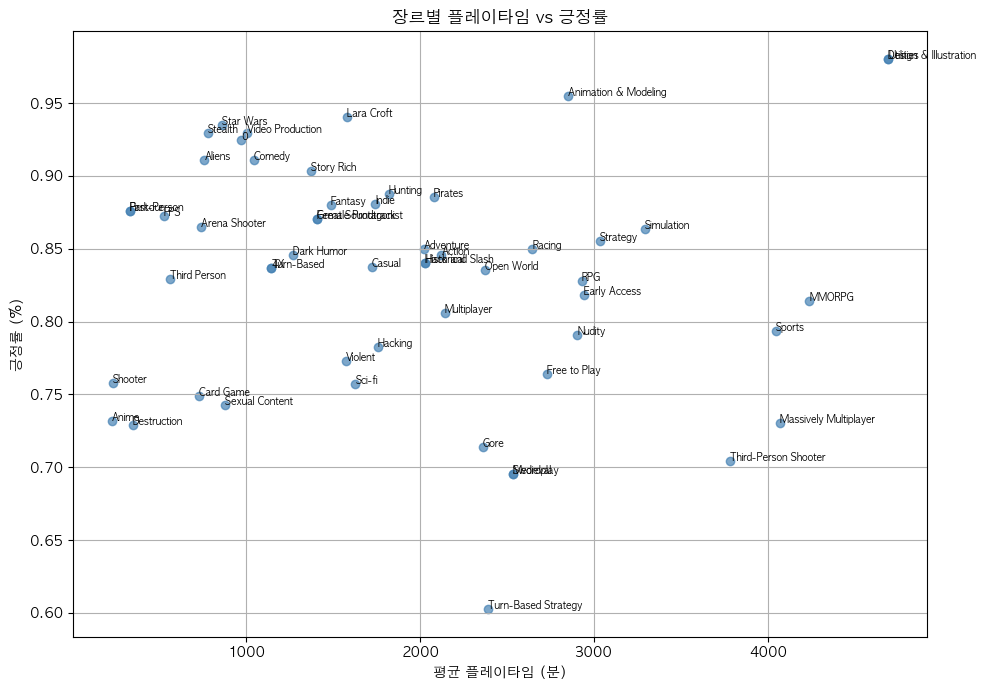

In [22]:
plt.figure(figsize=(10,7))
plt.scatter(genre["avg_playtime"], genre["avg_positive_rate"], color="steelblue", alpha=0.7)

for _, row in genre.iterrows():
    plt.text(row["avg_playtime"], row["avg_positive_rate"], row["genre_name"], fontsize=7)

plt.xlabel("평균 플레이타임 (분)")
plt.ylabel("긍정률 (%)")
plt.title("장르별 플레이타임 vs 긍정률")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 가성비 TOP 20 게임

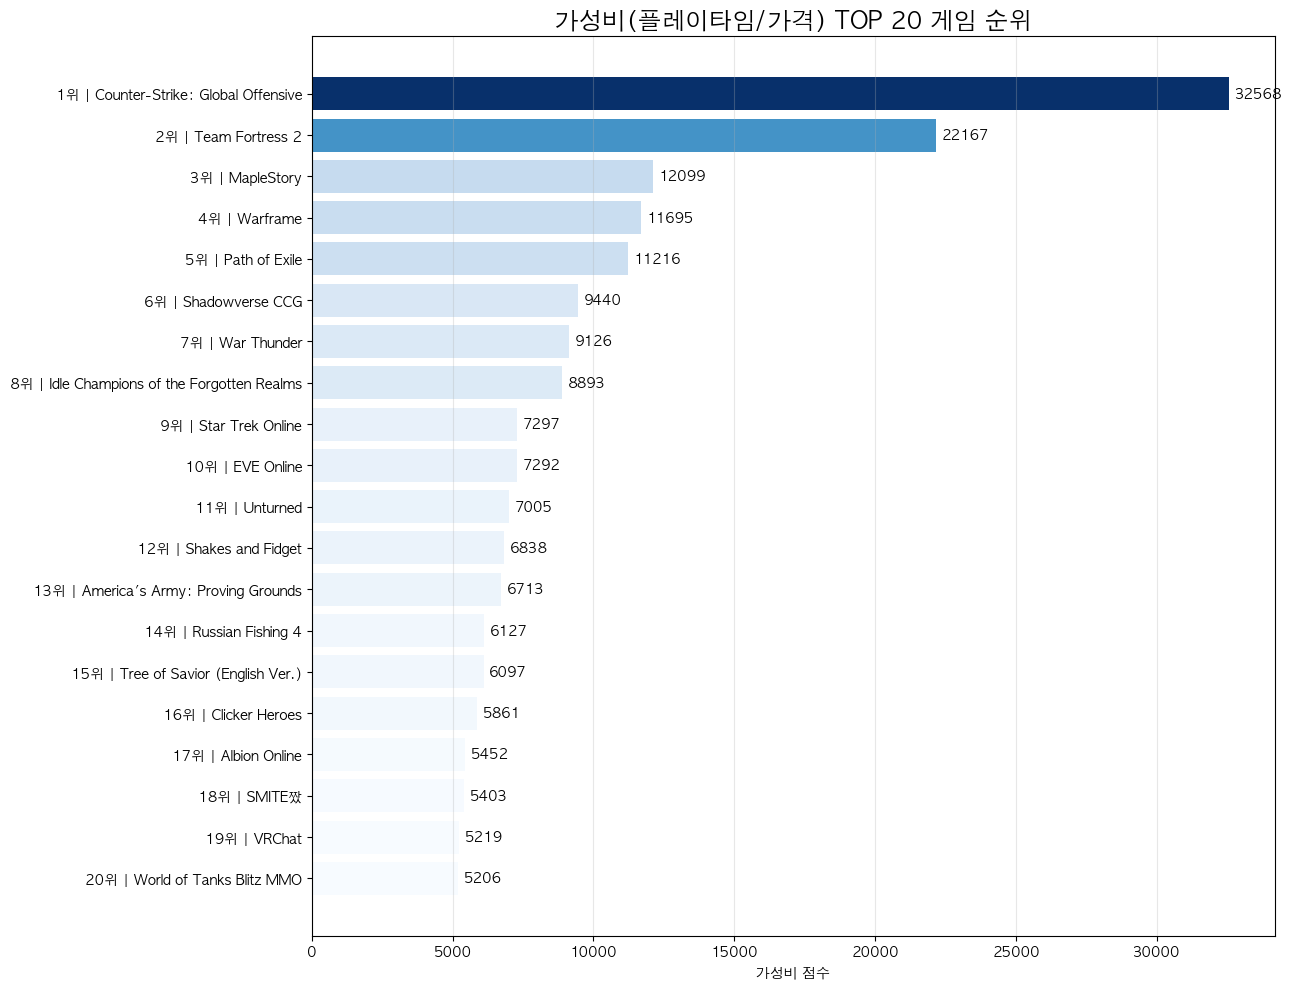

In [ ]:
df = play.merge(
    review,
    on=["appid","genre_id","genre_name"],
    how="left"
).merge(
    moi_raw[["appid","price","avg_playtime","positive_rate","market_opportunity_index"]],
    on="appid",
    how="left"
)

df["avg_playtime_game"] = df["avg_playtime_x"].fillna(df["avg_playtime_y"])
df["positive_rate_game"] = df["positive_rate_x"].fillna(df["positive_rate_y"])
df["price_game"] = df["price_x"].fillna(df["price_y"])
df["value_score"] = df["avg_playtime_game"] / (df["price_game"] + 1)
df["name"] = df["name_x"].fillna(df["name_y"])

df_game = df.drop_duplicates(subset="appid", keep="first")

top20 = df_game.sort_values("value_score", ascending=False).head(20).copy()
top20["rank"] = range(1, 21)
top20["label"] = top20["rank"].astype(str) + "위 | " + top20["name"]

plt.figure(figsize=(13,10))

norm = (top20["value_score"] - top20["value_score"].min()) / \
       (top20["value_score"].max() - top20["value_score"].min())

bars = plt.barh(
    top20["label"],
    top20["value_score"],
    color=plt.cm.Blues(norm)
)

plt.gca().invert_yaxis()
plt.title("가성비(플레이타임/가격) TOP 20 게임 순위", fontsize=17, weight="bold")
plt.xlabel("가성비 점수")
plt.grid(axis="x", alpha=0.3)

for bar, score in zip(bars, top20["value_score"]):
    plt.text(
        bar.get_width() + 200,
        bar.get_y() + bar.get_height()/2,
        f"{score:.0f}",
        va="center"
    )

plt.tight_layout()
plt.show()